# DD2437 - Sign Classification
Philip Rettig, Yoahn Pellerin, Romain Darous.

## Importing modules
And setting up the programming environment

In [1]:
# Modules to load data
import zipfile
import os
import json

# Other modules
import numpy as np
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Settingan an environment variable
path = '/content/drive/MyDrive/PATH_TO_FOLDER_OF_signCLassification.ipynb'

## Data pre-processing
1. Extracted .json files from the compressed file containing the frame per frame pose extraction for each video,
2. Looking for sign tokens that have several videos,
3. Using some of them to buil a train set using resample methods,
4. Keeping the others for the test set.

### 1. Extracting data

In [4]:
# Loading the .json files from the compressed file
zip_path = path + 'poses.zip'
extraction_path = './'

# Maximum number of .json files to extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get a list of all files in the zip archive
    all_files = zip_ref.namelist()

    # Filter out the list to include only JSON files
    json_files = [f for f in all_files if f.endswith('.json') and 'fras' not in f.split('-')]

    # Limit the number of files to extract to max_files
    files_to_extract = json_files[:]

    # Extract only the selected files
    for file in files_to_extract:
        zip_ref.extract(file, extraction_path)

# List the contents of the extracted directory to verify
extracted_files = os.listdir(extraction_path)
print("Extracted files:", len(extracted_files))  # This may include non-JSON files already present in the directory


Extracted files: 4


In [5]:
out_folder_path = './out'

# List all files in the "out" folder
files = os.listdir(out_folder_path)

# Filter out JSON files
json_files = [file for file in files if file.endswith('.json')]

In [6]:
json_files[3].split('-')

['original', '03959', 'tecken.json']

### 2. Selecting signs for classification

In [7]:
def get_sgn_translation(file_name) :
  split_name = file_name.split('-')

  idx = 0
  while (split_name[idx] != 'tecken.json' and split_name[idx] != 'fras') :
    idx += 1
  idx -= 1

  sgn = ''
  for i in range(idx) :
    sgn += split_name[i] + "-"
  sgn = sgn[:-1]
  return sgn

In [8]:
# Building a dictionary with sign token names and the amount of video per sign token
sgn_name_dict = {}

for file_name in json_files :
  if 'fras' not in file_name :
    # Finding sign translation
    sgn = get_sgn_translation(file_name)

    # Adding the sign to the dictionary
    if sgn in sgn_name_dict.keys() :
      sgn_name_dict[sgn] += 1
    else : sgn_name_dict[sgn] = 1


# Sorting the dict by descending value of token number
sorted_sgn_name = sorted(sgn_name_dict.items(), key=lambda item:-item[1])

In [9]:
sorted_sgn_name[:10]

[('forvanad', 16),
 ('hjartinfarkt', 11),
 ('fa', 11),
 ('jasa', 9),
 ('byta', 9),
 ('bara', 8),
 ('elva', 8),
 ('stor', 8),
 ('ekvation', 8),
 ('bryta-ut', 8)]

Let's try fist a classification of 10 different tokens

In [10]:
# Keeping only the tokens with the biggest content
sgn_nb = 10
kept_signs = sorted(np.array(sorted_sgn_name)[:sgn_nb,0])
print(kept_signs)

# Building a label - sign equivalent
label_sgn_dict = {}
sgn_label_dict = {}
for i in range(sgn_nb) :
  label_sgn_dict[i] = kept_signs[i]
  sgn_label_dict[kept_signs[i]] = i


['bara', 'bryta-ut', 'byta', 'ekvation', 'elva', 'fa', 'forvanad', 'hjartinfarkt', 'jasa', 'stor']


In [11]:
label_sgn_dict

{0: 'bara',
 1: 'bryta-ut',
 2: 'byta',
 3: 'ekvation',
 4: 'elva',
 5: 'fa',
 6: 'forvanad',
 7: 'hjartinfarkt',
 8: 'jasa',
 9: 'stor'}

In [12]:
sgn_label_dict

{'bara': 0,
 'bryta-ut': 1,
 'byta': 2,
 'ekvation': 3,
 'elva': 4,
 'fa': 5,
 'forvanad': 6,
 'hjartinfarkt': 7,
 'jasa': 8,
 'stor': 9}

Label for each video will be a vector of size 10 with zero everywhere except for the associated sign, where the coefficient will be 1.

### 3. Loading data features for the chosen signs

Given the signs we want, we will get the associated .json filenames. We will build at the same time a text set made of sign tokens (shorter videos).

In [13]:
# Getting the files that we want to open
subset_json_files = []

for file_name in json_files:
  sgn = get_sgn_translation(file_name)
  if sgn in kept_signs :
      json_path = os.path.join(out_folder_path, file_name)
      subset_json_files.append(json_path)

We will keep only the hands coordinates as a first experience. We also build a test set at the same time

In [14]:
train_hand_features_per_video = []
test_hand_features_per_video = []

train_labels = []
test_labels = []

frame_step = 4 # step between every kept frames

max_frames = 0

for file_name in subset_json_files:
    with open(file_name, 'r') as file:
        data = json.load(file)
        frame_nb = len(data.keys())
        frames = list(data.keys())
        video_hands_flattened = []
        for i in range(0, frame_nb, frame_step):
          frame_hands = data[frames[i]]['hands']
          frame_hands_flattened = torch.flatten(torch.tensor(frame_hands, dtype=torch.float))
          video_hands_flattened.append(frame_hands_flattened)
        video_hands_flattened_tensor = torch.stack(video_hands_flattened, dim=0)

        # Finding the maximal number of frames
        if (len(video_hands_flattened) > max_frames) :
          max_frames = len(video_hands_flattened)

        # Building the label for the video
        file_name = file_name[6:]
        sgn = get_sgn_translation(file_name)

        label = sgn_label_dict[sgn]
        one_hot_vector = [0]*sgn_nb
        one_hot_vector[label] = 1

        if 'tecken' in file_name and test_labels.count(one_hot_vector) < 2 :
          test_hand_features_per_video.append(video_hands_flattened_tensor)
          test_labels.append(one_hot_vector)

        else :
          train_hand_features_per_video.append(video_hands_flattened_tensor)
          train_labels.append(one_hot_vector)



In [15]:
print("Max number of frames : ", max_frames)

Max number of frames :  86


Now let's add **padding** so that we have the same number of images per video. We will use a mask to avoid take padding into account while training our model.

In [16]:
# Adding padding to every videos
feature_nb = train_hand_features_per_video[0].shape[1]
pad_value = -10

# For training data
for i in range(len(train_hand_features_per_video)) :
  video = train_hand_features_per_video[i]
  if video.shape[0] < max_frames :
    nb_frames = max_frames - video.shape[0]
    padding = torch.full((nb_frames, feature_nb), pad_value)
    video = torch.cat((video, padding), dim=0)
    train_hand_features_per_video[i] = video

# For testing data
for i in range(len(test_hand_features_per_video)) :
  video = test_hand_features_per_video[i]
  if video.shape[0] < max_frames :
    nb_frames = max_frames - video.shape[0]
    padding = torch.full((nb_frames, feature_nb), pad_value)
    video = torch.cat((video, padding), dim=0)
    test_hand_features_per_video[i] = video

# Finally, converting all the sets we have in array sets
X_train = np.array(train_hand_features_per_video)
Y_train = np.array(train_labels)

X_test = np.array(test_hand_features_per_video)
Y_test = np.array(test_labels)

print("X_train : ", X_train.shape)
print("Y_train : ", Y_train.shape)

print("X_test : ", X_test.shape)
print("Y_test : ", Y_test.shape)


X_train :  (76, 86, 84)
Y_train :  (76, 10)
X_test :  (20, 86, 84)
Y_test :  (20, 10)


Let's now perform **resampling** to get the same amount of data per class.

In [17]:
# Assuming Y_train contains one-hot encoded labels where each label is represented as a vector of size 10

# Determine the number of samples for each label
label_counts = np.sum(Y_train, axis=0)

# Find the minimum number of samples among all labels
#max_samples = np.max(label_counts)
min_samples = np.min(label_counts)

# Resample X_train and Y_train to have the same number of samples for each label
resampled_X_train = []
resampled_Y_train = []
for label_idx in range(Y_train.shape[1]):
    # Get indices of samples with the current label
    label_indices = np.where(Y_train[:, label_idx] == 1)[0]
    selected_indices = np.random.choice(label_indices, min_samples, replace=False)
    #selected_indices = np.concatenate((selected_indices, np.random.choice(label_indices, max_samples - min_samples, replace=True)), axis = 0)

    # Add the corresponding samples from X_train and Y_train to the resampled data
    resampled_X_train.extend(X_train[selected_indices])
    resampled_Y_train.extend(Y_train[selected_indices])

# Convert the lists of samples to numpy arrays
resampled_X_train = np.array(resampled_X_train)
resampled_Y_train = np.array(resampled_Y_train)

# Suffling the datasets
indexes = [i for i in range(resampled_X_train.shape[0])]
np.random.shuffle(indexes)

resampled_X_train = resampled_X_train[indexes]
resampled_Y_train = resampled_Y_train[indexes]

# Check the shape of the resampled X_train and Y_train
print("Resampled X_train shape:", resampled_X_train.shape)
print("Resampled Y_train shape:", resampled_Y_train.shape)

Resampled X_train shape: (60, 86, 84)
Resampled Y_train shape: (60, 10)


Finnaly, let's add **noise** to the datapoints to improve the generalisation.

In [18]:
# Building the noise
mean = 0
sigma = 0.001
noise = np.random.normal(mean, sigma, resampled_X_train.shape)

# Adding it to the data
noised_resampled_X_train = resampled_X_train + noise
noised_resampled_Y_train = resampled_Y_train

# Resetting the padding value
noised_resampled_X_train[noised_resampled_X_train < 0] = pad_value

# Suffling the datasets
indexes = [i for i in range(resampled_X_train.shape[0])]
np.random.shuffle(indexes)

noised_resampled_X_train = resampled_X_train[indexes]
noised_resampled_Y_train = resampled_Y_train[indexes]



We finally have a dataset that can be used for training a model.
Some improvement that ce be thought for later investigations :
1. Resampling to have the same amount of data per sign,
2. Not using phrases, only teckens,
3. Add noise to the labels to improve generalisation.

This has been done. The test set contains a single token of each sign.

## Model creation

Videos are time-series based data. We will use RNNs based on LSTM units to train our model.

In [74]:
# Module to run the ANN model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
from keras.callbacks import TensorBoard, EarlyStopping

# LSTM model to perform sign classification given key positions
class SignClassifier(keras.Model) :
    def __init__(self, input_shape, output_shape, epochs, pad_value):
        """
        Initializes the SignClassifier object.

        Args:
            input_shape (tuple): The shape of the input data (nb_frames, frame_features_nb)
            output_shape (tuple): The shape of the output data (class_nb,)
            epochs (int): The number of epochs to train the model. Recommended : 2000

        Returns:
            None
        """

        super(SignClassifier, self).__init__()

        # Parameters of the model
        self.input_shpe = input_shape
        self.output_shpe = output_shape
        self.log_dir = os.path.join('logs')
        self.tb_callback = TensorBoard(log_dir=self.log_dir)
        self.early_stopping = EarlyStopping(patience = 5, restore_best_weights = True)
        self.epochs = epochs
        self.pad_value = pad_value

        # Building model
        self.build_model()

    def build_model(self) :
        self.model = Sequential()

        # From one LSTM layer to another, the output is used as input of the next one
        self.model.add(Masking(mask_value=self.pad_value, input_shape=self.input_shpe))
        self.model.add(LSTM(64, activation='tanh', return_sequences = True))
        self.model.add(LSTM(128, activation='tanh', return_sequences = True))
        self.model.add(LSTM(64, activation='tanh', return_sequences = False))

        # Now, we keep the values of the short-memory and long-memory to perform classification
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))

        # Finally adding the output layer
        self.model.add(Dense(self.output_shpe, activation='softmax'))

        # Compiling the model
        opt = keras.optimizers.Adam(clipnorm=1.0)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    def fit(self, X_train, Y_train, X_val, Y_val) :
        return self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=self.epochs, callbacks=[self.tb_callback, self.early_stopping])

    def fit(self, X_train, Y_train) :
        return self.model.fit(X_train, Y_train, epochs=self.epochs, callbacks=[self.tb_callback])

    def predict(self, X) :
        return self.model.predict(X)

## Fitting the model to the data

In [88]:
import matplotlib.pyplot as plt

# Function that allows the training of the model
def training(X_train, Y_train) :
  # training the model
  model = SignClassifier(input_shape = tuple(X_train.shape[1:]), output_shape = Y_train.shape[1], epochs = 150, pad_value = pad_value)
  history = model.fit(X_train, Y_train)
  return model, history

def training_val(X_train, Y_train, X_val, Y_val) :
  # training the model
  model = SignClassifier(input_shape = tuple(X_train.shape[1:]), output_shape = Y_train.shape[1], epochs = 100, pad_value = pad_value)
  history = model.fit(X_train, Y_train, X_val, Y_val)
  return model, history

# Function that allows to compute the accuracy of the model
def get_accuracy(Y_true, Y_pred) :
  correct_pred = 0
  for i in range(Y_true.shape[0]) :
    if np.array_equal(Y_true[i], Y_pred[i]) :
      correct_pred += 1
  accuracy = correct_pred / Y_true.shape[0]
  return accuracy

# Function that gathers all the performances of the model
def model_performances(X_train, Y_train, X_test, Y_test, model, history) :

  # Testing the model on the train and test sets
  Y_test_predicted = model.predict(X_test)
  Y_train_predicted = model.predict(X_train)

  max_values = np.max(Y_test_predicted, axis=1)
  Y_test_predicted_decision = np.where(Y_test_predicted == max_values[:, np.newaxis], 1, 0)

  max_values = np.max(Y_train_predicted, axis=1)
  Y_train_predicted_decision = np.where(Y_train_predicted == max_values[:, np.newaxis], 1, 0)

  # Getting test and train prediction accuracy
  train_accuracy = get_accuracy(Y_train, Y_train_predicted_decision)
  print("Prediction precision on the train set : ", np.round(train_accuracy,3)*100, "%")

  test_accuracy = get_accuracy(Y_test, Y_test_predicted_decision)
  print("Prediction precision on the test set : ", test_accuracy*100, "%")

  # Plotting the evolution of the metrics
  plt.figure()
  plt.plot(history.history['loss']/np.max(history.history['loss']), label='training loss')
  plt.plot(history.history['categorical_accuracy'], label='categorical accuracy')
  #plt.plot(history.history['val_loss']/np.max(history.history['val_loss']), label='validation loss')
  plt.title("Metrics evolution across training epochs")
  plt.legend()
  plt.xlabel('Epochs')
  plt.show()


In [89]:
val_size = 0

### 1. Training data with resampling

In [90]:
resampled_model, resampled_history = training(resampled_X_train, resampled_Y_train) #training_val(resampled_X_train[:-val_size], resampled_Y_train[:-val_size], resampled_X_train[-val_size:], resampled_Y_train[-val_size:])

Epoch 1/150
2/2 [==============================] - 19s 380ms/step - loss: 2.3081 - categorical_accuracy: 0.1167
Epoch 2/150
2/2 [==============================] - 1s 371ms/step - loss: 2.3002 - categorical_accuracy: 0.1000
Epoch 3/150
2/2 [==============================] - 1s 417ms/step - loss: 2.3020 - categorical_accuracy: 0.1167
Epoch 4/150
2/2 [==============================] - 1s 390ms/step - loss: 2.2875 - categorical_accuracy: 0.1667
Epoch 5/150
2/2 [==============================] - 1s 375ms/step - loss: 2.2807 - categorical_accuracy: 0.2000
Epoch 6/150
2/2 [==============================] - 1s 375ms/step - loss: 2.2651 - categorical_accuracy: 0.2333
Epoch 7/150
2/2 [==============================] - 1s 405ms/step - loss: 2.2547 - categorical_accuracy: 0.1833
Epoch 8/150
2/2 [==============================] - 1s 364ms/step - loss: 2.2357 - categorical_accuracy: 0.1667
Epoch 9/150
2/2 [==============================] - 1s 369ms/step - loss: 2.2147 - categorical_accuracy: 0.2167


2/2 [==============================] - 0s 94ms/step
Prediction precision on the train set :  100.0 %
Prediction precision on the test set :  40.0 %


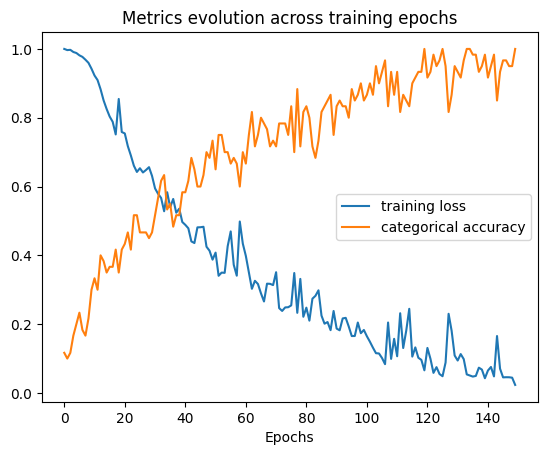

In [91]:
#model_performances(resampled_X_train[:-val_size], resampled_Y_train[:-val_size], X_test, Y_test, resampled_model, resampled_history)
model_performances(resampled_X_train, resampled_Y_train, X_test, Y_test, resampled_model, resampled_history)

### 2. Training data with resampling and noise

In [92]:
noised_model, noised_history = noised_model, noised_history = training(noised_resampled_X_train, noised_resampled_Y_train) #training_val(noised_resampled_X_train[:-val_size], noised_resampled_Y_train[:-val_size], noised_resampled_X_train[-val_size:], noised_resampled_Y_train[-val_size:])

Epoch 1/150
2/2 [==============================] - 19s 366ms/step - loss: 2.3058 - categorical_accuracy: 0.0833
Epoch 2/150
2/2 [==============================] - 1s 376ms/step - loss: 2.3030 - categorical_accuracy: 0.1000
Epoch 3/150
2/2 [==============================] - 1s 346ms/step - loss: 2.2944 - categorical_accuracy: 0.1167
Epoch 4/150
2/2 [==============================] - 1s 336ms/step - loss: 2.2867 - categorical_accuracy: 0.1167
Epoch 5/150
2/2 [==============================] - 1s 360ms/step - loss: 2.2762 - categorical_accuracy: 0.1500
Epoch 6/150
2/2 [==============================] - 1s 351ms/step - loss: 2.2569 - categorical_accuracy: 0.2167
Epoch 7/150
2/2 [==============================] - 1s 364ms/step - loss: 2.2308 - categorical_accuracy: 0.2667
Epoch 8/150
2/2 [==============================] - 1s 386ms/step - loss: 2.1948 - categorical_accuracy: 0.2833
Epoch 9/150
2/2 [==============================] - 1s 349ms/step - loss: 2.1564 - categorical_accuracy: 0.3000


2/2 [==============================] - 0s 100ms/step
Prediction precision on the train set :  98.3 %
Prediction precision on the test set :  45.0 %


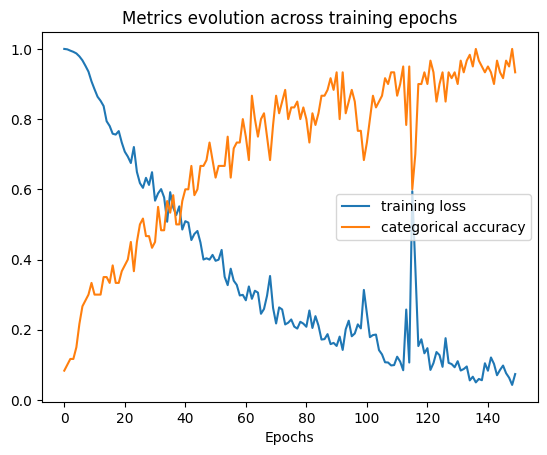

In [93]:
#model_performances(noised_resampled_X_train[:-val_size], noised_resampled_Y_train[:-val_size], X_test, Y_test, noised_model, noised_history)
model_performances(noised_resampled_X_train, noised_resampled_Y_train, X_test, Y_test, noised_model, noised_history)